In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rfpimp import plot_corr_heatmap
from rfpimp import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

/Users/lilianabadillo/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_boston = pd.read_csv("data/BostonHousing.csv")

In [3]:
df_boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df_boston.drop('b', axis=1, inplace=True)

In [5]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


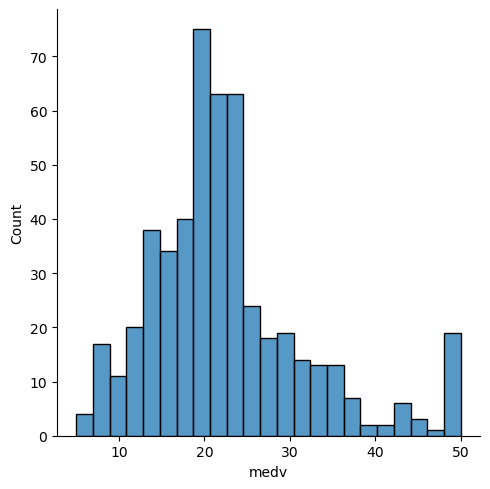

In [6]:
sns.displot(df_boston.medv)

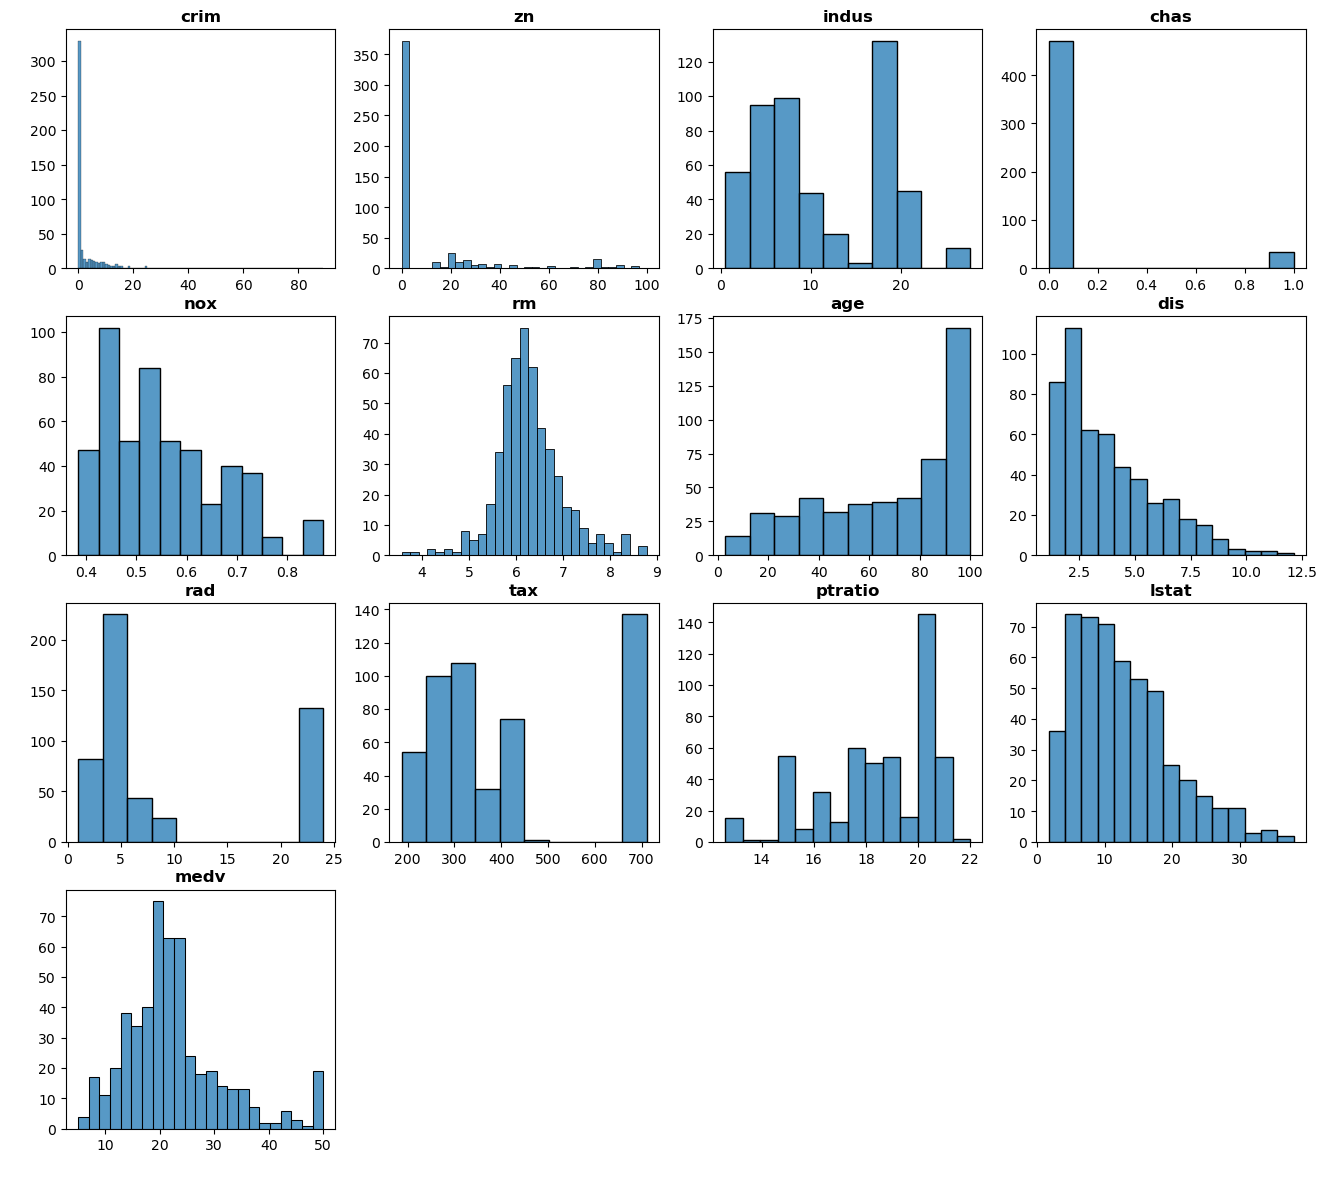

In [7]:
plt.figure(figsize= (16,18))
for i,col in enumerate(df_boston.columns):
    plt.subplot(5,4, i+1)
    sns.histplot(df_boston[col])
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

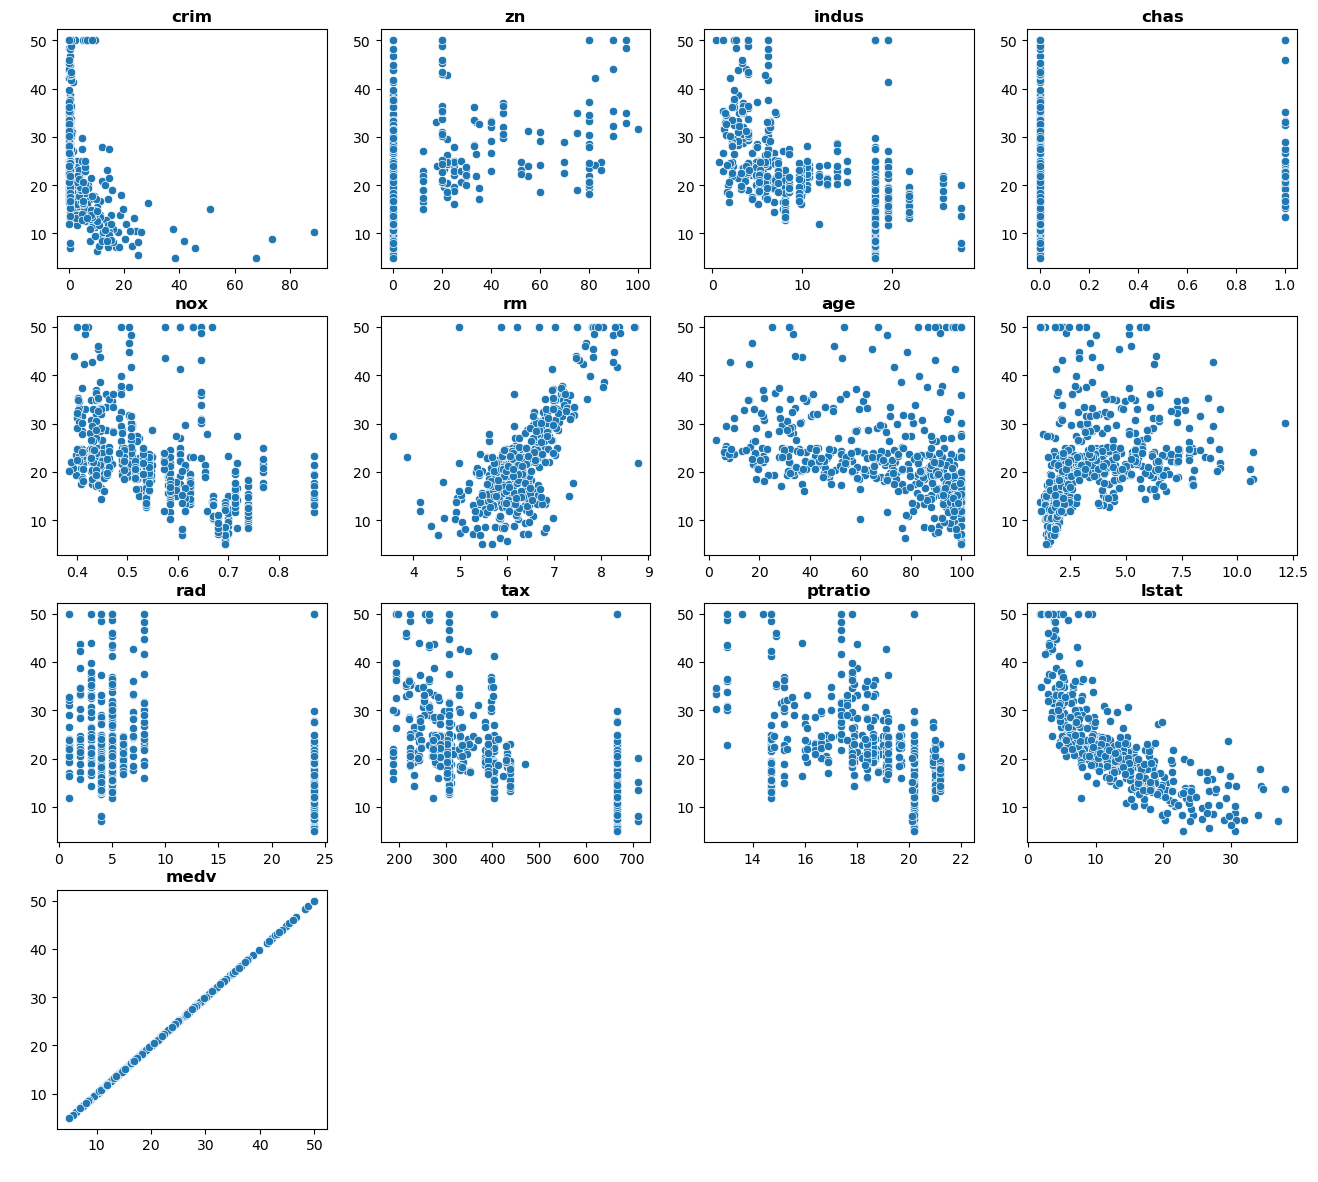

In [8]:
plt.figure(figsize= (16,18))
for i,col in enumerate(df_boston.columns):
    plt.subplot(5,4, i+1)
    sns.scatterplot(x=df_boston[col], y=df_boston.medv)
    plt.title(col, weight = 'bold')
    plt.ylabel(" ")
    plt.xlabel(" ")

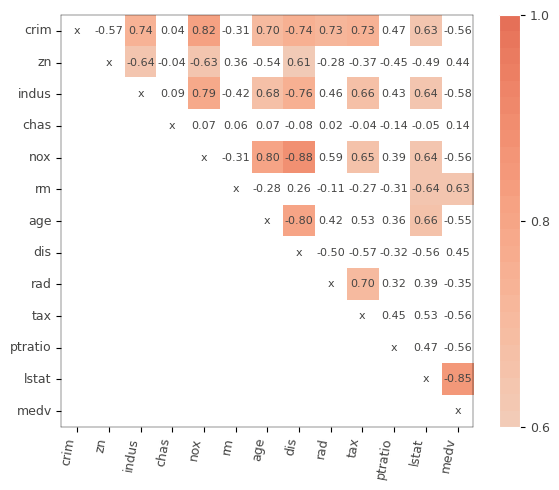

In [9]:
corr = plot_corr_heatmap(df_boston, figsize=(7,5))
corr.view()

## Data preprocessing

In [10]:
y = df_boston.medv
X = df_boston.drop(['medv', 'nox'], axis=1)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=.20,
                                                    random_state=42)

## Train random forest

In [12]:
rf = RandomForestRegressor(random_state=42,
                           n_estimators= 100, 
                           min_samples_leaf = 20,
                           max_depth= 7,
                           n_jobs=-1,
                           oob_score=True,
                          )

In [13]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=20, n_jobs=-1,
                      oob_score=True, random_state=42)

In [14]:
print('R^2 Training Score: {:.4f}\nR^2 Validation Score: {:.4f}'.format(rf.score(X_train, y_train), 
                                                                         rf.score(X_val, y_val)))

R^2 Training Score: 0.8177
R^2 Validation Score: 0.7542


## Feature importance using Random Forest

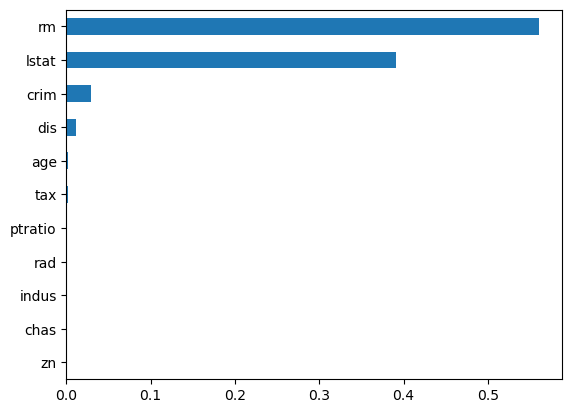

In [15]:
feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

## Permutation importance

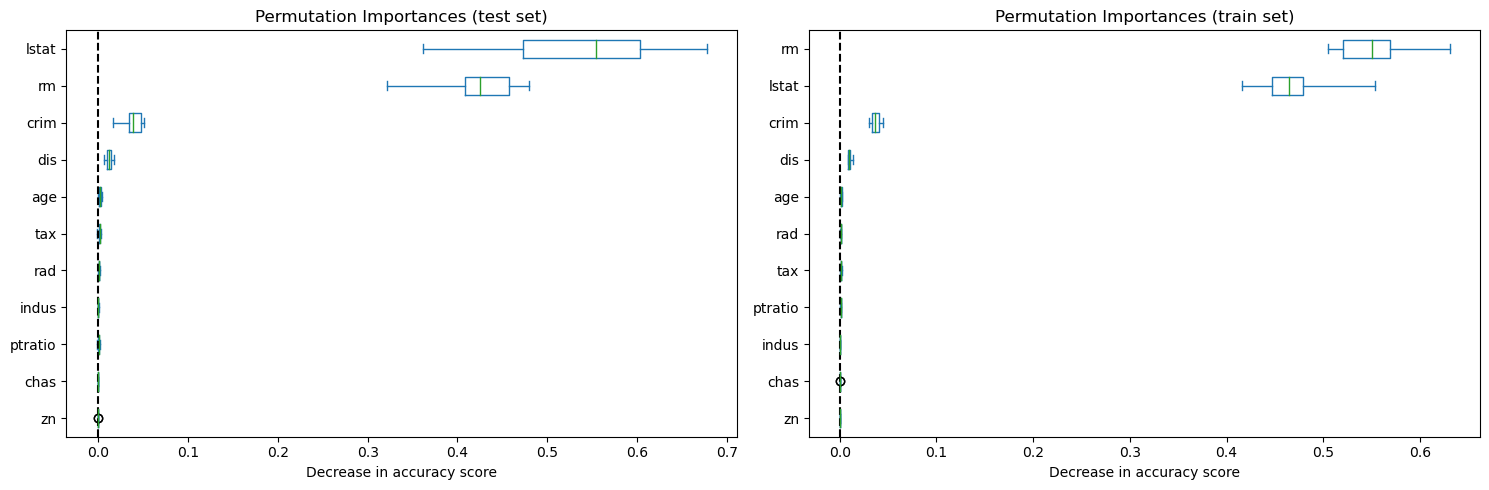

In [16]:
result_test = permutation_importance(
    rf, X_val, y_val, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

## Drop column importances

<AxesSubplot:ylabel='Feature'>

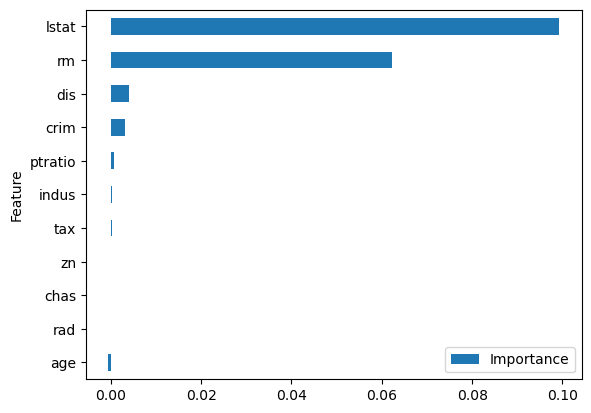

In [17]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


imp = dropcol_importances(rf, X, y)
imp.plot(kind = 'barh')

## Improve model performance

In [18]:
cols_to_train = ["lstat", "rm", "dis", "crim"]

In [19]:
y = df_boston.medv
X = df_boston[cols_to_train]

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=.20,
                                                    random_state=42)

In [21]:
rf = RandomForestRegressor(random_state=42,
                           n_estimators= 100, 
                           min_samples_leaf = 20,
                           max_depth= 7,
                           n_jobs=-1,
                           oob_score=True,
                          )

In [22]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=20, n_jobs=-1,
                      oob_score=True, random_state=42)

In [23]:
print('R^2 Training Score: {:.4f}\nR^2 Validation Score: {:.4f}'.format(rf.score(X_train, y_train), 
                                                                         rf.score(X_val, y_val)))

R^2 Training Score: 0.8153
R^2 Validation Score: 0.7543


In [24]:
y_pred_val = rf.predict(X_val)
y_pred_train = rf.predict(X_train)

print('RMSE Training Score: {:.4f}\nRMSE Validation Score: {:.4f}'.format(mean_squared_error(y_train, y_pred_train, squared=False), 
                                                                          mean_squared_error(y_val, y_pred_val, squared=False)))

RMSE Training Score: 4.0057
RMSE Validation Score: 4.2449


## Try other models 

In [25]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_pred_val = xgb.predict(X_val)
y_pred_train = xgb.predict(X_train)

print('RMSE Training Score: {:.4f}\nRMSE Validation Score: {:.4f}'.format(mean_squared_error(y_train, y_pred_train, squared=False), 
                                                                          mean_squared_error(y_val, y_pred_val, squared=False)))

/Users/lilianabadillo/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE Training Score: 0.0732
RMSE Validation Score: 3.5259
